## Testing Saturation in Loopback

**Note: we have 60 dB of in-line attenuation between the DAC and ADC channels in loopback.** 

*Here is some language added to the demo notebook on saturation (maybe this will become a standalone at some point but for now I am just copying and pasting this info for reference):*

If the ZCU216 recieves too large of a pulse, it can cause it to saturate. When the ZCU216 saturates, it will raise an "interrupt" and will then automatically turn on its built-in attenuators to add an additional 15 dB of attenuation, which can degrade the signal integrity. The current iteration of the RF board adds 60-90 dB of gain, so saturation can quickly become an issue without enough external attenuation.

The following cells can be used to check if the ZCU216 is saturating. The main function is ```clear_interupts()```. As implied by its name it clears and then prints out the interrupts raised by the ZCU216. It can sometimes take several passes to clear an interrupt. 

There are two significant interrupts to look for when it comes to saturation: ```XRFDC_ADC_OVR_RANGE_MASK``` and ```XRFDC_ADC_OVR_VOLTAGE_MASK```. 

```XRFDC_ADC_OVR_RANGE_MASK```: warns that the ADC units (ADU) exceed the ADC's usable input range. This interrupt on its own will **not** cause the ZCU216 to add 15 dB of attenuation. 


```XRFDC_ADC_OVR_VOLTAGE_MASK```: warns that the the input voltage is outside of the ADC safe range (e.g., the ZCU216 has recieved too much voltage). **This will cause the ZCU216 to add 15 dB more attenuation.** (at least -15 dB is what we expect - but see the calculation below, its closer to ~ 9 dB)

In [10]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from qick import *
from qick.rfboard import * 
import time

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [11]:
# Load bitstream with custom overlay
soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-28_216_tprocv2r21_rfb_standard/qick_216_rfb.bit', clk_output=None)

soccfg = soc

print(soccfg)

QICK running on ZCU216, software version 0.2.324

Firmware configuration (built Sat Sep 28 20:39:53 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 

In [12]:
# define DAC and ADC ports as defined in the QICK firmware
GEN_CH=5 # DAC 
RO_CH=0  # ADC

In [99]:
import xrfdc

# 0x0000F000 is only used by DAC, I think
# 0x03000000 is not used?
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/XRFdc_IntrEnable
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/Interrupt-Handling
# https://github.com/Xilinx/embeddedsw/blob/master/XilinxProcessorIPLib/drivers/rfdc/src/xrfdc_hw.h

# same Sho's original definition just modified to return the raised flags
def custom_clear_interrupts(soc, verbose=False):
    interrupt_masks = [
        (0x0000000F, "XRFDC_IXR_FIFOUSRDAT_MASK"), # FIFO over/underflow, linked to XRFDC_ADC_FIFO_OVR_MASK?
        (0x00000FF0, "XRFDC_ADC_IXR_DATAPATH_MASK"), # overflow/saturation in datapath (e.g. decimation), linked to XRFDC_ADC_DAT_OVR_MASK?
        (0x00FF0000, "XRFDC_SUBADC_IXR_DCDR_MASK"), # analog input over/under full-scale range for individual sub-ADCs, linked to OVR_RANGE interrupt
        (0x04000000, "XRFDC_ADC_OVR_VOLTAGE_MASK"), # analog input exceeding ADC safe range - gen3 RFSoC
        (0x08000000, "XRFDC_ADC_OVR_RANGE_MASK"), # analog input exceeding ADC full-scale range
        (0x10000000, "XRFDC_ADC_CMODE_OVR_MASK"), # analog input common-mode voltage above spec - gen3 RFSoC
        (0x20000000, "XRFDC_ADC_CMODE_UNDR_MASK"), # analog input common-mode voltage below spec - gen3 RFSoC
        (0x40000000, "XRFDC_ADC_DAT_OVR_MASK"),
        (0x80000000, "XRFDC_ADC_FIFO_OVR_MASK"),
    ]
    prints = []
    arr = xrfdc._ffi.new("unsigned int [1]")
    allclear = False
    attempts = 0
    maxattempts = 5
    while not allclear:
        allclear = True
        for name, cfg in soc['adcs'].items():
            tile, block = cfg['index']
            status = xrfdc._lib.XRFdc_GetIntrStatus(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,arr)
            if status != 0: print("error in reading interrupts:", status)
            interrupts = arr[0]
            if interrupts != 0:
                allclear = False
                names = []
                for mask, name in interrupt_masks:
                    if (mask & interrupts) != 0:
                        interrupts &= 0xFFFFFFFF - mask
                        names.append(name)
                if interrupts != 0: print("unrecognized interrupts:", interrupts)
                if verbose or attempts == 0:
                    print("pass %d, interrupts on tile %d block %d:"%(attempts, tile, block), hex(arr[0]), names)
                    prints.extend(names)
                status = xrfdc._lib.XRFdc_IntrClr(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,0xffffffff)
                if status != 0: print("error in clearing interrupts:", status)
        attempts += 1
        if attempts >= maxattempts:
            print("giving up")
            break
    if attempts > 1 and attempts < maxattempts:
        print("successfully cleared all interrupts in %d attempts"%(attempts-1))
        
    if len(prints) == 0:
        prints.append(None)
        
    return prints

# just used to print out set attenuation 
def print_attenuator(soc, ro_ch):
    tile, block = [int(x) for x in soc['readouts'][ro_ch]['adc']]
    adc = soc.rf.adc_tiles[tile].blocks[block]
    print(adc.DSA)
    
def set_attenuator(soc, ro_ch, val, verbose=False):
    tile, block = [int(x) for x in soc['readouts'][ro_ch]['adc']]
    adc = soc.rf.adc_tiles[tile].blocks[block]
    if verbose: print("before:", adc.DSA)
    adc.DSA['Attenuation'] = val
    if verbose: print("after:", adc.DSA)
        
def decibel_voltage_ratio(V1,V2):
    return 20 * np.log10(V2/V1)

In [14]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
#                        style="const",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

In [81]:
# sorry kind of hard coded but its a just an array of attenuations I'm sweeping through

'''alternate going down 1 dB on each DAC attenuator 
and than once they are both at 0 dB, increment the ADC attenuator down 1 dB per step'''

attenuator1 = [30] + [i for i in range(29, -1, -1) for _ in (0,1)] + 31*[0]
attenuator2 = [i for i in range(30, 0, -1) for _ in (0,1)] + 32*[0]
attenuator3 = (len(attenuator2)-31)*[30] + [i for i in range(30, -1, -1)]

attenuation_list = np.column_stack((attenuator1,attenuator2,attenuator3))

## Comment on running clear_interrupts:

Sara and I noticed that you have to run clear_interrupts twice for it to properly clear the flags. That is say we send a pulse and get the overrange interrupt - if we increase the attenuation well above which this interrupt occurs and send another run it again, you will still see the overrange flag pop up. You have to run it again at the same attenuation to see that there were actually no flags raised.

## Sweeping from 90 to 0 total dB on the RF Board:
The cell below sweeps through 90 to 0 total dB (running each setting twice to properly clear the interrupts as noted right above). This will take some time to run... espcially because I added a time.sleep(5) between loops just to give the system a rest between measurements.

In [82]:
saturationDictionary = {"attenuation":[],"max_magnitude":[],"overrange":[],"overvoltage":[]}

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 3000,
          'freq': 3000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)

over_range_flag = 'XRFDC_ADC_OVR_RANGE_MASK'
over_voltage_flag = 'XRFDC_ADC_OVR_VOLTAGE_MASK'

for attenuation in tqdm(attenuation_list):
    # loop through multiple attenuations for each attenuator 
    DAC_ATN1 = attenuation[0]
    DAC_ATN2 = attenuation[1]
    ADC_ATN = attenuation[2]

    print("set DAC attenuators:", soc.rfb_set_gen_rf(config['gen_ch'], DAC_ATN1, DAC_ATN2))
    print("set ADC attenuators:", soc.rfb_set_ro_rf(config['ro_ch'], ADC_ATN))

    # need to run it twice to clear interrupts properly
    for i in range(0,2,1):
        iq_list = prog.acquire_decimated(soc, soft_avgs=100)
        flags = custom_clear_interrupts(soc, verbose=True)
        t = prog.get_time_axis(ro_index=0)
        iq = iq_list[0]

        if i == 1:
            saturationDictionary["attenuation"] += [DAC_ATN1 + DAC_ATN2 + ADC_ATN]
            saturationDictionary["max_magnitude"] += [np.max(np.abs(iq.dot((1,1j))))]

            if over_range_flag in flags:
               OR = 1 # append 1 to list if overrange flag is raised
            else:
               OR = 0 # append 0 to list if overrange flag is not raised

            if over_voltage_flag in flags:
               OV = 1 # append 1 to list if overvoltage flag is raised
            else:
               OV = 0 # append 0 to list if overvoltage flag is not raised

            saturationDictionary["overrange"] += [OR]
            saturationDictionary["overvoltage"] += [OV]
    time.sleep(5) # just to the system time to rest between iterations

  0%|          | 0/92 [00:00<?, ?it/s]

set DAC attenuators: (30.0, 30.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (29.0, 30.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (29.0, 29.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (28.0, 29.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (28.0, 28.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (27.0, 28.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (27.0, 27.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (26.0, 27.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (26.0, 26.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (25.0, 26.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (25.0, 25.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (24.0, 25.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (24.0, 24.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (23.0, 24.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (23.0, 23.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (22.0, 23.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (22.0, 22.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (21.0, 22.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (21.0, 21.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (20.0, 21.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (20.0, 20.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (19.0, 20.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (19.0, 19.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (18.0, 19.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (18.0, 18.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (17.0, 18.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (17.0, 17.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (16.0, 17.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (16.0, 16.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (15.0, 16.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (15.0, 15.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (14.0, 15.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (14.0, 14.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (13.0, 14.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (13.0, 13.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (12.0, 13.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (12.0, 12.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (11.0, 12.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (11.0, 11.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (10.0, 11.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (10.0, 10.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (9.0, 10.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (9.0, 9.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (8.0, 9.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (8.0, 8.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (7.0, 8.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (7.0, 7.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (6.0, 7.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (6.0, 6.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (5.0, 6.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (5.0, 5.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (4.0, 5.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

set DAC attenuators: (4.0, 4.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8340000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8100000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (3.0, 4.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (3.0, 3.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (2.0, 3.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (2.0, 2.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (1.0, 2.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (1.0, 1.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (0.0, 1.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 30.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 29.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 28.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 1 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 27.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 26.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 25.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 24.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 23.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 22.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 21.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 20.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 19.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2c400000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x85b0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 3 attempts


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2c810000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8060000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8080000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8d30000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 18.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x80b0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8080000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
successfully cleared all interrupts in 3 attempts
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 17.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x87f0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x86f0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 16.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 15.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 14.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 13.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 12.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 11.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 10.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 9.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 8.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
pass 4, interrupts on tile 2 block 0: 0x8ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 7.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 6.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 5.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 4.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x247b0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x247f0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24fe0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24df0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24df0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24fb0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24f70000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24b70000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x249a0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24d70000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24790000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24db0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24fd0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24fb0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24fa0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24fb0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x247f0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24dd0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x247d0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up
set DAC attenuators: (0.0, 0.0)
set ADC attenuators: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x24d80000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24b60000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24fb0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x24e60000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24fd0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


  0%|          | 0/100 [00:00<?, ?it/s]

pass 0, interrupts on tile 2 block 0: 0x247f0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x246f0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 0: 0x24e30000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 3, interrupts on tile 2 block 0: 0x247d0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 4, interrupts on tile 2 block 0: 0x24ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
giving up


In [96]:
# find the first time the over-range and over-voltage flags are raised
range_pos = np.where(np.array(saturationDictionary["overrange"]) == 1)[0][0]
voltage_pos = np.where(np.array(saturationDictionary["overvoltage"]) == 1)[0][0]

ADU Voltage drop = -8.84 dB


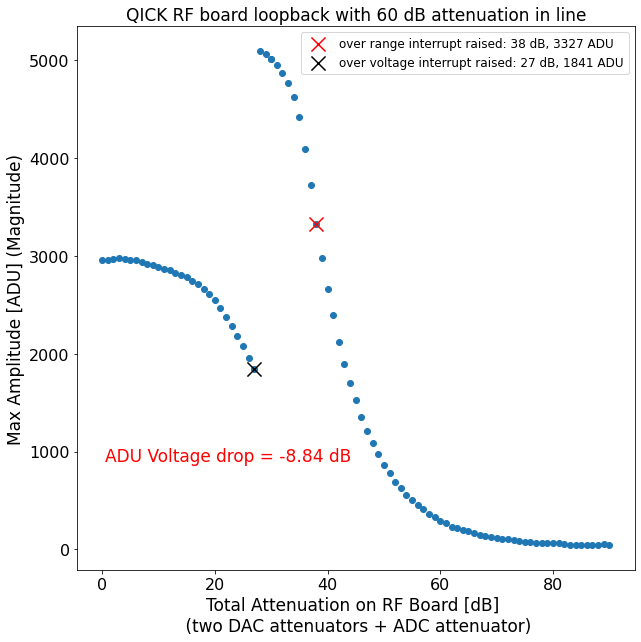

In [130]:
totalatn = saturationDictionary["attenuation"]
mag = saturationDictionary["max_magnitude"]

fig,ax = plt.subplots(figsize = (10,10))
plt.scatter(totalatn,mag)
plt.scatter(totalatn[range_pos],mag[range_pos],marker = 'x',color='red',s=200,label = "over range interrupt raised: {} dB, {} ADU".format(int(totalatn[range_pos]),int(mag[range_pos])))
plt.scatter(totalatn[voltage_pos],mag[voltage_pos],marker = 'x',color='black',s=200,label = "over voltage interrupt raised: {} dB, {} ADU".format(int(totalatn[voltage_pos]),int(mag[voltage_pos])))

xlims = ax.get_xlim()

plt.xlim(xlims[0],xlims[1])
plt.xticks(fontsize = 16)
plt.xlabel("Total Attenuation on RF Board [dB] \n (two DAC attenuators + ADC attenuator)",fontsize = 17)
plt.yticks(fontsize = 16)
plt.ylabel("Max Amplitude [ADU] (Magnitude)",fontsize = 17)
plt.legend(fontsize = 12)
plt.title("QICK RF board loopback with 60 dB attenuation in line",fontsize = 17);

dB_drop = decibel_voltage_ratio(np.max(mag),mag[voltage_pos])
plt.text(0.05,0.2,'ADU Voltage drop = {} dB'.format(np.round(dB_drop,2)),transform = ax.transAxes,fontsize = 17,color = 'red')

print('ADU Voltage drop = {} dB'.format(np.round(dB_drop,2)))